### Importing necessary modules

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('ggplot')
%config Completer.use_jedi = False
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

from sklearn.utils import resample
from scipy.stats import norm

### Downloading the data for SPDRS and Equity

In [4]:
spdrs = {
    'XLC': 'Communication Services',
    'XLY': 'Consumer Discretionary',
    'XLP': 'Consumer Staples',
    'XLE': 'Energy',
    'XLF': 'Financials',
    'XLV': 'Health Care',
    'XLI': 'Industrials',
    'XLB': 'Materials',
    'XLRE': 'Real Estates',
    'XLK': 'Technology',
    'XLU': 'Utilities'
}

**For the Equity index fund we selected Vanguard 500 Index Fund (VOO)**

In [5]:
try:
    df = pd.read_csv('./spdrs_equity.csv').set_index("Date", drop=True)
    
except:
    eq_etf = 'VOO'
    symbols = list(spdrs.keys())
    print(symbols)
    df = pdr.get_data_yahoo([*symbols, eq_etf], start='2014-01-01', end='2020-01-01')['Adj Close']
    df.to_csv('./spdrs_equity.csv')

In [6]:
df.head()

,VOO,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,
2013-12-31,148.141632,40.122818,NaN,67.715195,15.501633,45.382710,32.015926,35.646816,NaN,29.938189,49.410664,60.736691
2014-01-02,146.810410,39.801613,NaN,66.751213,15.416534,44.748779,31.702387,35.207253,NaN,29.480881,49.134388,60.454964
2014-01-03,146.679047,39.706131,NaN,66.506401,15.522905,44.870358,31.550104,35.140892,NaN,29.386269,49.250248,60.291382
2014-01-06,146.311234,39.489105,NaN,66.598221,15.537092,44.609833,31.496344,35.008198,NaN,29.433573,49.045250,59.918755
2014-01-07,147.222061,39.419666,NaN,67.103149,15.544182,44.887714,31.783010,35.198952,NaN,29.693773,49.562172,60.282303


<AxesSubplot:xlabel='Date'>

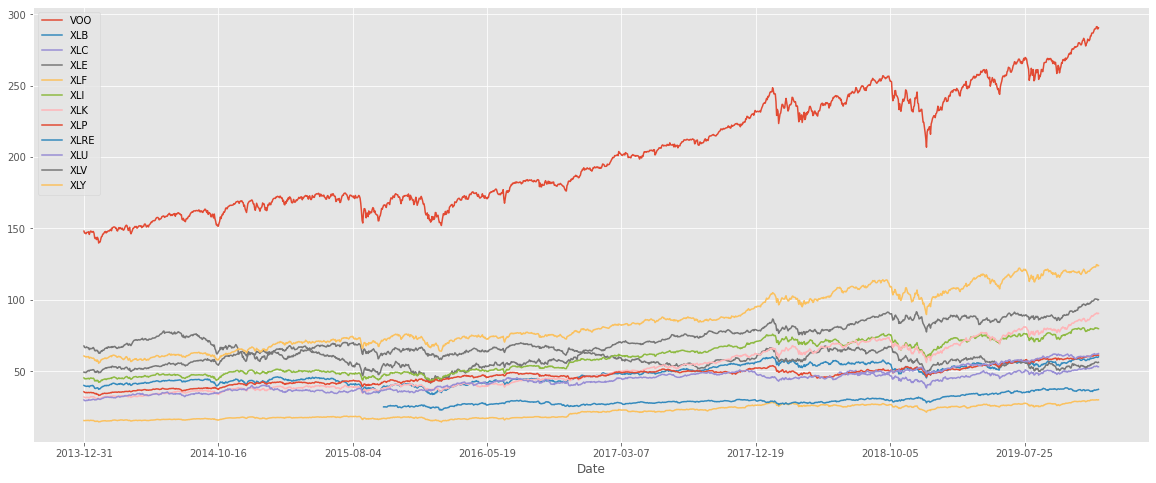

In [7]:
df.plot(figsize=(20,8))

### 2. Returns of all SPDRS and ETF

In [8]:
df_rets = np.log1p(df.pct_change())

<AxesSubplot:xlabel='Date'>

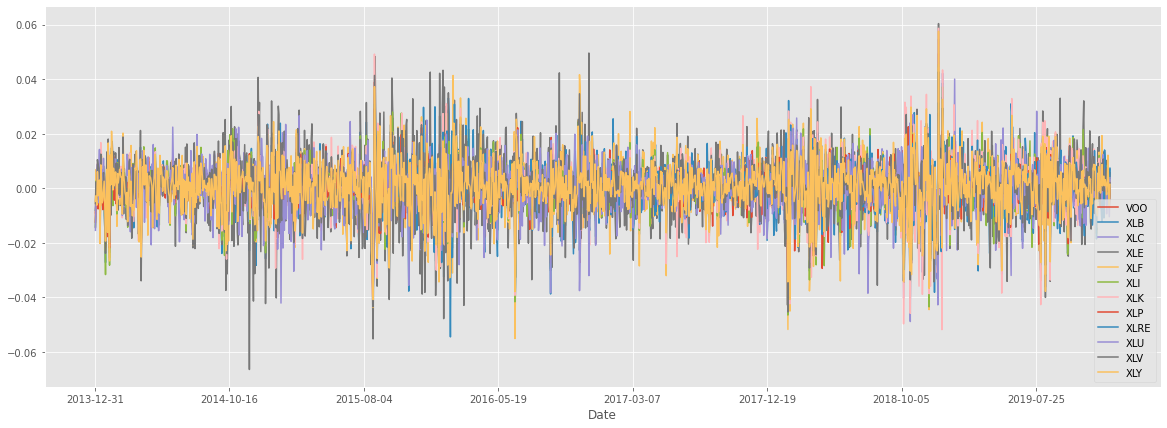

In [9]:
df_rets.plot(figsize=(20,7))

### 3. Data Summaries

In [10]:
data_sum = df_rets.describe()
data_sum.loc['interquantile range', :] = data_sum.loc['75%',:] - data_sum.loc['25%', :]
data_sum.loc['skew',:] = df_rets.skew()
data_sum.loc['kurtosis'] = df_rets.kurtosis()
data_sum = data_sum.loc[['mean', 'std', '50%', 'interquantile range','skew','kurtosis'], :].rename({'50%':'median'})
data_sum.head(10)

,VOO,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
mean,0.000446,0.000268,0.000222,-0.000122,0.000437,0.000374,0.000688,0.000359,0.000376,0.000486,0.000468,0.000473
std,0.008253,0.010225,0.011811,0.013112,0.010356,0.009468,0.010574,0.007306,0.009135,0.008840,0.009401,0.009227
median,0.000593,0.000708,0.001112,0.000148,0.000813,0.000799,0.001029,0.000451,0.000990,0.001231,0.000917,0.001150
interquantile range,0.007540,0.011454,0.011125,0.014139,0.010724,0.009743,0.010112,0.008060,0.009769,0.010096,0.009978,0.009676
skew,-0.529487,-0.293965,-0.251747,-0.188353,-0.439275,-0.503088,-0.473263,-0.478549,-0.605887,-0.628238,-0.392270,-0.417225
kurtosis,3.842801,1.541539,2.951389,1.847992,2.703275,2.339613,3.476553,2.051423,2.655165,1.852977,2.148347,2.988870


### 3.4 Bootstraped Standard Deviation

In [11]:
bootstrap_std = pd.DataFrame(columns=df_rets.columns)
for i in range(1000):
    bootstrap_std.loc[i, :] = resample(df_rets, replace=True, n_samples=1000).std()
    
    

In [15]:
pd.DataFrame({'bootstrap_std':bootstrap_std.std(), 'kurtosis':data_sum.loc['kurtosis', :]})

,bootstrap_std,kurtosis
VOO,0.000302,3.842801
XLB,0.000293,1.541539
XLC,0.000821,2.951389
XLE,0.000394,1.847992
XLF,0.000353,2.703275
XLI,0.000303,2.339613
XLK,0.000379,3.476553
XLP,0.000232,2.051423
XLRE,0.000375,2.655165
XLU,0.000279,1.852977


### 3.5 Data generation process

## 4. Data Inference

Two SPDRs taken as XLI and XLK

In [99]:
def fit_plot(x, ax):
    mu, std = norm.fit(x)
    ax2 = ax.twinx()
    sns.histplot(x, ax=ax)
    sns.kdeplot(x, ax=ax2, label='Heavy tailed')
    
    xmin, xmax = plt.xlim()
    xx = np.linspace(xmin, xmax, 100)
    p = norm.pdf(xx, mu, std)
    sns.lineplot(x=xx, y=p, label='Gaussian', ax=ax2)

Now fitting the normal distribution for both:

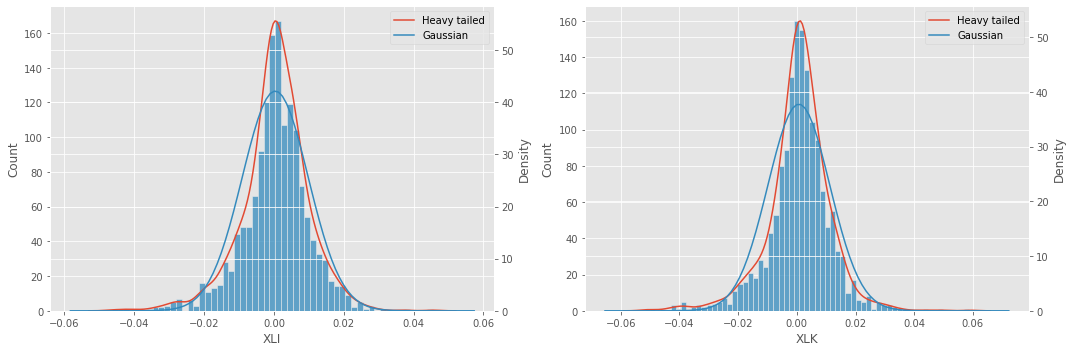

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))   
axe = axes.flatten()
selected_spdr = ['XLI', 'XLK']
for i in range(2):
    x = df_rets.loc[:,selected_spdr[i]].dropna()
    ax = axe[i]
    fit_plot(x,ax)
fig.tight_layout()
plt.show()

For both of the SPDR's gaussian distribution doesn't fit well, they are heavy tailed distribution. We can see for all the other spdrs and etf

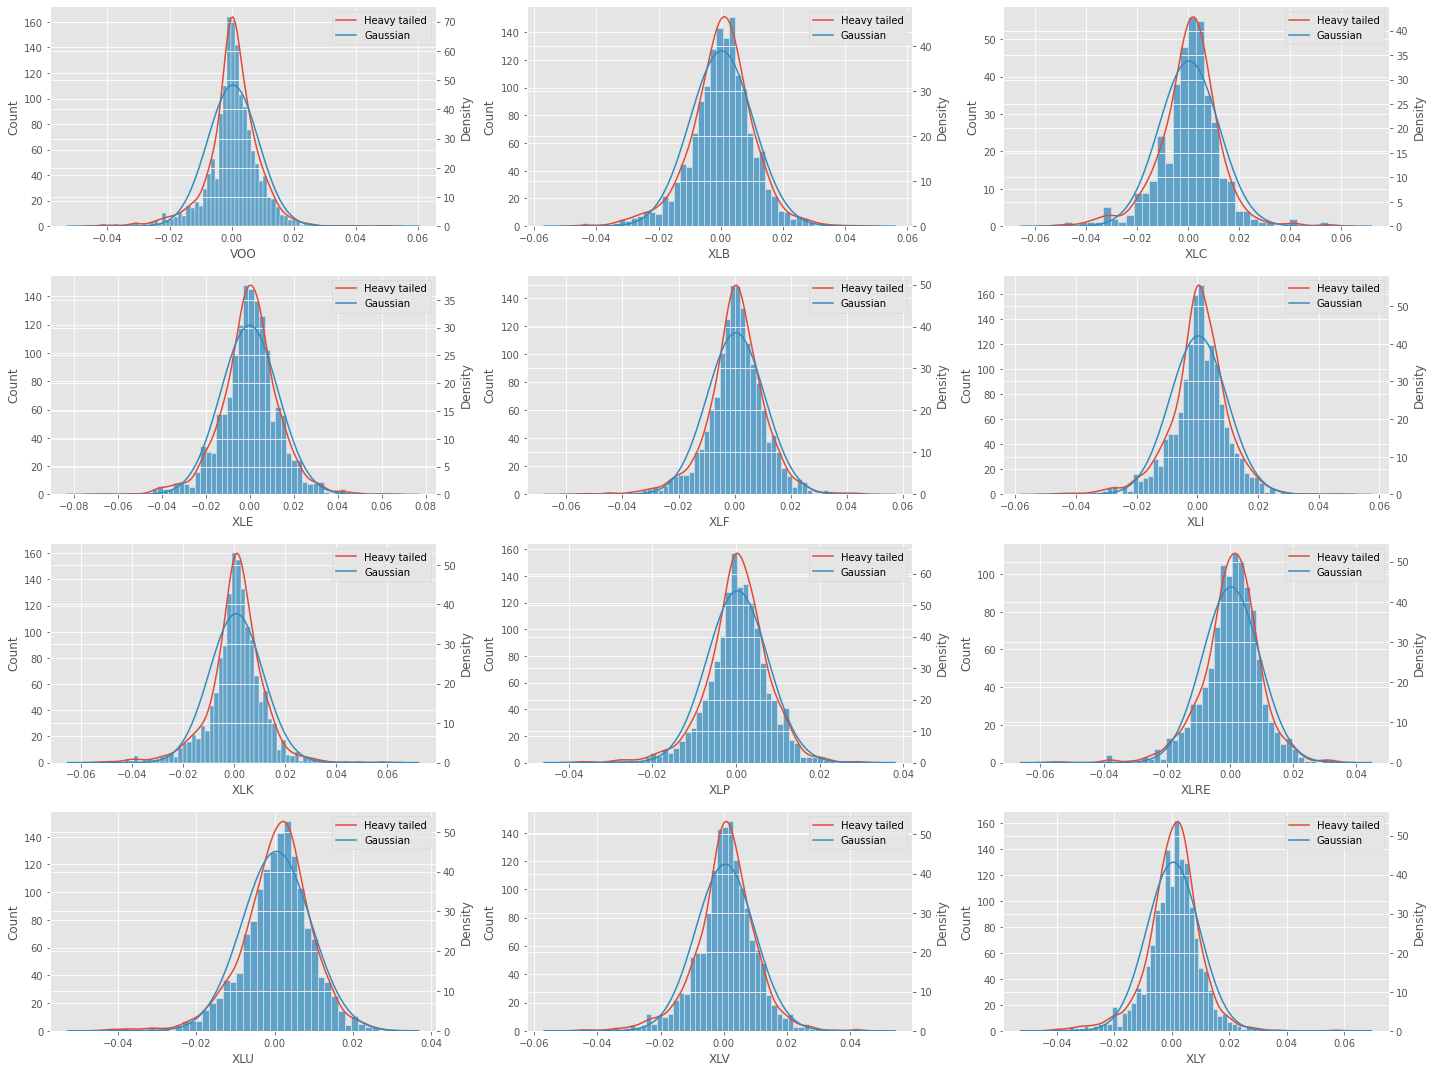

In [102]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))   
axe = axes.flatten()
for i in range(12):
    x = df_rets.iloc[:,i].dropna()
    ax = axe[i]
    fit_plot(x,ax)
fig.tight_layout()
plt.show()
    
    

#### Which distribution fits well

From all the return series, the SPDR's and ETF, They are mostly fit a heavy tail distribution well due to the negative skewed returns. 

### 5 Data comparisons

In [105]:
from pycopula.copula import GaussianCopula, ArchimedeanCopula

In [108]:
two_rets = df_rets.loc[:, selected_spdr].dropna()

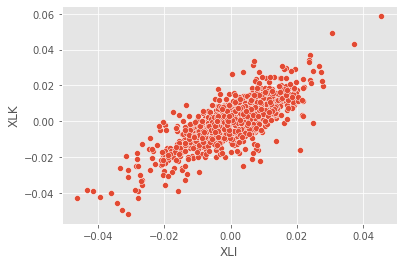

In [114]:
sns.scatterplot(x=two_rets.iloc[:,0], y=two_rets.iloc[:,1])
plt.show()

In [112]:
two_rets.corr()

,XLI,XLK
XLI,1.000000,0.784873
XLK,0.784873,1.000000


In [113]:
two_rets.cov()

,XLI,XLK
XLI,0.000090,0.000079
XLK,0.000079,0.000112


In [127]:
gaussian_copula = GaussianCopula(dim=2)
X = two_rets.to_numpy()
gaussian_copula.fit(X, method='cmle')

Fitting Gaussian copula.


In [129]:
gaussian_copula.

TypeError: correlations() missing 1 required positional argument: 'X'

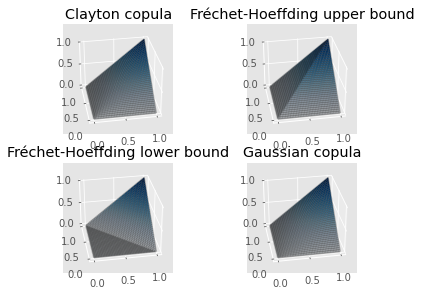

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pycopula.copula import *
from mpl_toolkits.mplot3d import Axes3D
from pycopula.visualization import cdf_2d

# Storing the copulas in array
copulas = []
copulas.append(ArchimedeanCopula(family="clayton", dim=2))
copulas.append(Copula(dim=2, name='frechet_up'))
copulas.append(Copula(dim=2, name='frechet_down'))
copulas.append(GaussianCopula(dim=2))

names = [ 'Clayton copula', 'Fréchet-Hoeffding upper bound', 'Fréchet-Hoeffding lower bound', 'Gaussian copula' ]

fig = plt.figure()
index = 1

# For each copula
for c, i in zip(copulas, range(1,5)):
     # We get the CDF values
     u, v, C = cdf_2d(c)

     # Subplotting the current copula's CDF
     ax = fig.add_subplot(220 + i, projection='3d', title=names[i-1])
     X, Y = np.meshgrid(u, v)
     ax.set_zlim(0, 1)
     ax.plot_surface(X, Y, C, cmap=cm.Blues)
     ax.plot_wireframe(X, Y, C, color='black', alpha=0.3)
     ax.view_init(30, 260)
plt.tight_layout()
plt.show()